In [7]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")

from scipy import constants
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import itertools as it

from shapely.geometry.polygon import Polygon
from Hamiltonian import discrete_system_coordinates
from shapely.ops import unary_union
import poisson
from potential import gate_potential, linear_problem_instance
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    TwoDEGLayer,
)

from ccode.plotting import plot_gates
from ccode.finite_system import finite_system
import ccode.parameters as pm
import ccode.solvers as sl
import ccode.tools as tl
from ccode.gates import rectangular_gate, half_disk_gate

import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options

import kwant
from tqdm import tqdm

In [8]:
a = 10e-9

In [9]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction_design/"

In [10]:
# Geometry parameters

a = 10e-9
L = 41
width = 12
gap = 4

R = L/np.sqrt(2)

zmin = -0.5
zmax = 0.5
xmax = R
xmin = -xmax
ymin = 0
ymax = R + L - width
total_width = 2*xmax
total_length = ymax

# Poisson parameters

thickness_dielectric = 1
thickness_twoDEG = 1
thickness_gates = 3

grid_spacing_twoDEG = 0.5
grid_spacing_normal = 1
grid_spacing_dielectric = 1
grid_spacing_air = 5
grid_spacing_gate = grid_spacing_twoDEG

permittivity_metal = 5000
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

# Make gates

Y = unary_union(
    (
        Polygon(half_disk_gate(R=R, npts=3)).difference(Polygon(half_disk_gate(R=R-width*np.sqrt(2), npts=3))),
        Polygon(rectangular_gate(center=(0,R+L/2-width), width=width, length=L))
    )
)

gates = Polygon(rectangular_gate(center=(0, (R+L-width)/2), length=R+L-width-1,width=2*R)).difference(Y)

aux_rectangle_1 = rectangular_gate(length=R+2*gap, width=R+gap, center=(R/2, R/2-width/2))
aux_rectangle_2 = rectangular_gate(length=R+2*gap, width=R+gap, center=(-R/2, R/2-width/2))


def gate_coords(obj, difference=None, common=None, gap=None):

    if type(common) == np.ndarray:
        return np.round(np.array(list(obj.intersection(Polygon(common)).exterior.coords)), 2)

    else:
        if gap is not None:
            return np.round(np.array(list(obj.difference(Polygon(difference).buffer(gap)).exterior.coords)), 2)
        else:
            return np.round(np.array(list(obj.difference(Polygon(difference)).exterior.coords)), 2)


gates_vertex = [gate_coords(gates[0], common = aux_rectangle_2), 
                gate_coords(gates[2], difference = aux_rectangle_1), 
                gate_coords(gates[2], difference = aux_rectangle_2), 
                gate_coords(gates[1], common = aux_rectangle_1), 
                gate_coords(gates[0], difference = aux_rectangle_2, gap = gap), 
                gate_coords(gates[1], difference = aux_rectangle_1, gap = gap)]

gates_name = ['left_1', 'left_2', 'right_1', 'right_2', 'top_1', 'top_2']


# Solve for Poisson system

layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    SimpleChargeLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG,
        add_to_previous_layer=False,
        fix_overlap=False,
        z_bottom=None
    ),
    center=True,
)

height = thickness_twoDEG / 2

layout.add_layer(
    SimpleChargeLayer(
        "Al2O3",
        thickness_dielectric,
        permittivity_Al2O3,
        grid_spacing_dielectric,
        add_to_previous_layer = False,
        fix_overlap = False,
        z_bottom = None
    )
)

height += thickness_dielectric


layout.add_layer(OverlappingGateLayer(thickness_gates,
                                      permittivity_metal,
                                      grid_spacing_gate,
                                      layer_name=gates_name,
                                      gate_objects=gates_vertex,
                                      remove_points=False,
                                      add_to_previous_layer=False,
                                      z_bottom=height,
                                      fix_overlap=True
                                     )
            )


height += thickness_gates + 1
layout.add_layer(
    SimpleChargeLayer("Al2O3_2", thickness_dielectric, permittivity_Al2O3, grid_spacing_dielectric,
                     add_to_previous_layer = False,
                     z_bottom = height, fix_overlap = False)
)

height += thickness_dielectric + 1
thickness_accumulation_gate = 2
layout.add_layer(PlanarGateLayer("global_accumul", 
                                 thickness_accumulation_gate, 
                                 permittivity_metal, 
                                 grid_spacing_gate, 
                                 gate_coords = [],
                                 second_layer = [],
                                 fix_overlap = False,
                                 z_bottom = height
                                )
                )

poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)

site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('charge', 'twoDEG')], boundaries=None
)

crds = site_coords[:, [0, 1]]
grid_spacing = grid_spacing_twoDEG
offset = crds[0]%grid_spacing

checking intersection
finished checking intersection
Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


In [29]:
def linear_Hamiltonian(
    poisson_params,
    kwant_params,
    general_params,
    gates,
    phis = [0.0, 0.0]
):

    ## non-linear part of the Hamiltonian
    
    voltages = {}
    
    for gate in gates: voltages[gate] = 0.0
    
    kp = kwant_params
    pp = poisson_params
    
    charges = {}
    potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'][:, [0, 1]],
            pp['site_indices'],
            voltages,
            charges,
            offset = kp['offset'][[0, 1]],
            grid_spacing = kp['grid_spacing']
        )
    
    
    
    general_params.update(potential=potential)
    general_params['phi1'] = phis[0]
    general_params['phi2'] = phis[1]
    
    bare_hamiltonian = kp['finite_system_object'].hamiltonian_submatrix(
        sparse=True, params=kp['finite_system_params_object'](**general_params))
    
    
    hamiltonian_V = {}
    for gate in tqdm(gates):

        voltages_t = dict.fromkeys(voltages, 0.0)

        voltages_t[gate] = 1.0

        potential = gate_potential(
            pp['poisson_system'],
            pp['linear_problem'],
            pp['site_coords'][:, [0, 1]],
            pp['site_indices'],
            voltages_t,
            charges,
            offset = kp['offset'][[0, 1]],
            grid_spacing = kp['grid_spacing']
        )
    

        general_params.update(potential=potential)

        hamiltonian = kp['finite_system_object'].hamiltonian_submatrix(
            sparse=True, params=kp['finite_system_params_object'](**general_params))


        hamiltonian_V[gate] = hamiltonian - bare_hamiltonian

    return bare_hamiltonian, hamiltonian_V

In [30]:
# Build kwant system

R_a = R*a
width_a = width*a
l = 150 * a
w = 7 * a
boundaries = [xmin, xmax, ymin, ymax, min(grid_points[:, 2]), max(grid_points[:, 2])]
boundaries = np.array(boundaries) * a

geometry ={'nw_l': l, 'nw_w': w,
           's_w': boundaries[1] - boundaries[0],
           's_l': boundaries[3] - boundaries[2],
           'centers':[[-R_a+width_a/np.sqrt(2), 0],
                      [-(-R_a+width_a/np.sqrt(2)), 0], 
                      [0,boundaries[3]+l-a]
                     ]
          }

trijunction, f_params = finite_system(**geometry)
trijunction = trijunction.finalized()

In [20]:
voltage_regions = poisson_system.regions.voltage.tag_points
grid_points = poisson_system.grid.points

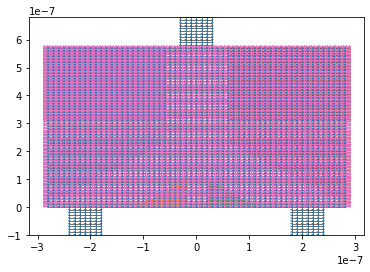

In [21]:
fig, ax = plt.subplots()
kwant.plot(trijunction, ax=ax)
ax.set_ylim(-10*a, boundaries[3]+10*a)

for name, indices in voltage_regions.items():
    grid_to_plot = a*grid_points[indices][:, [0, 1]]
    ax.scatter(grid_to_plot[:, 0], grid_to_plot[:, 1], s = 0.5)


In [306]:
poisson_params = {
    'poisson_system': poisson_system,
    'linear_problem': linear_problem,
    'site_coords': site_coords,
    'site_indices': site_indices,
}    

kwant_params = {
    'offset': offset,
    'grid_spacing': a,
    'finite_system_object': trijunction,
    'finite_system_params_object': f_params,
    
}

general_params = pm.junction_parameters(m_nw=pm.bands[0]*np.ones(3))

In [307]:
base_hamiltonian, linear_ham = linear_Hamiltonian(poisson_params, kwant_params, general_params, list(voltage_regions.keys()))

100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


In [12]:
grid_points = poisson_system.grid.points

In [13]:
def voltage_dict(depleted, acumulate, arm=None, arm_v=0):
    voltages = {}

    voltages['left_1'] = depleted
    voltages['left_2'] = depleted

    voltages['right_1'] = depleted
    voltages['right_2'] = depleted

    voltages['top_1'] = depleted
    voltages['top_2'] = depleted

    voltages['global_accumul'] = acumulate
    
    if arm is not None:
        voltages[arm+'_1'] = arm_v
        voltages[arm+'_2'] = arm_v

    return voltages

In [46]:
depleted = -3e-3
acumulate = 3e-3
voltages = voltage_dict(depleted, acumulate, arm='top', arm_v=-5e-3)

In [47]:
params = general_params

In [48]:
%%time

charges = {}
potential = gate_potential(
        poisson_system,
        linear_problem,
        site_coords[:, [0, 1]],
        site_indices,
        voltages,
        charges,
        offset = offset[[0, 1]],
        grid_spacing = kwant_params['grid_spacing']
    )

potential.update((x, y*-1) for x, y in potential.items())

params.update(potential=potential)

CPU times: user 574 ms, sys: 2.99 ms, total: 577 ms
Wall time: 574 ms


In [52]:
f_mu = f_params(**params)['mu']


def plot_f_mu(i):
    x, y = trijunction.sites[i].pos
    return f_mu(x, y)

In [55]:
kwant_sites = np.array(list(site.pos for site in trijunction.sites)) 

to_plot = [plot_f_mu(i) for i in range(len(kwant_sites))] 
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

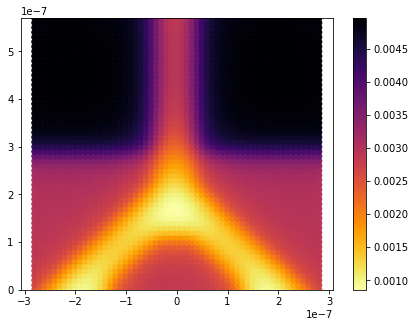

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
cax = ax.scatter(kwant_sites[:, 0 ], kwant_sites[:, 1], 
                 c = np.array(to_plot), cmap = 'inferno_r', 
                );
ax.set_ylim(0, 0.57e-6);
plt.colorbar(cax);

### Optimal phases: potential is fixed and Hamiltonian parameters are changed

In [94]:
def fixed_potential_solver(kwant_syst, base_params, eigenvecs=False, n=20):

    def solver(extra_params):

        system, f_params = kwant_system
        base_params.update(extra_params)
        ham_mat = system.hamiltonian_submatrix(sparse=True, params=f_params(**base_params))

        if eigenvecs:
            evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))
        else:
            evals = np.sort(
                sla.eigsh(ham_mat.tocsc(), k=n, sigma=0, return_eigenvectors=eigenvecs)
            )
            evecs = []

        return evals, evecs

    return solver

In [155]:
kwant_system = [trijunction, f_params]
params = pm.junction_parameters(m_nw=pm.bands[0]*np.ones(3))

In [358]:
arms = ['left', 'right', 'top']
potentials = []
depleted = -1.5e-3
acumulate = 4.5e-3
closed_arm = -5e-3

for arm in arms:
    voltages = voltage_dict(depleted, acumulate, arm=arm, arm_v=closed_arm)
    charges = {}
    potential = gate_potential(
            poisson_system,
            linear_problem,
            site_coords[:, [0, 1]],
            site_indices,
            voltages,
            charges,
            offset = offset[[0, 1]],
            grid_spacing = kwant_params['grid_spacing']
        )

    #potential.update((x, y*-1) for x, y in potential.items())
    potentials.append(potential)

In [359]:
params.update(potential=potentials[1])

In [360]:
solver = fixed_potential_solver(kwant_system, params, eigenvecs=True)

In [361]:
ens, vecs = solver({'phi0':np.pi})

In [362]:
ens

array([-3.31056501e-04, -3.27213015e-04, -3.25947584e-04, -3.24215228e-04,
       -3.04101022e-04, -1.77718483e-04, -1.04719516e-04, -4.90149805e-05,
       -1.21571914e-07, -1.65060835e-10,  1.65060835e-10,  1.21571914e-07,
        4.90149805e-05,  1.04719516e-04,  1.77718483e-04,  3.04101022e-04,
        3.24215228e-04,  3.25947584e-04,  3.27213015e-04,  3.31056501e-04])

In [363]:
density = kwant.operator.Density(trijunction, np.eye(4))

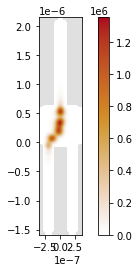

In [364]:
kwant.plotter.density(trijunction, density(vecs[7]));

In [348]:
phases = np.linspace(0, 2, 100) * np.pi
phis = [{'phi1': phi} for phi in phases]

In [349]:
args_db = db.from_sequence(phis)

In [350]:
%%time

with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])
    result = args_db.map(solver).compute()


KeyboardInterrupt



In [ ]:
energies = [element[0] for element in result]
energies = np.array(energies)

In [ ]:
for level in energies.T:
    plt.plot(phases/np.pi, level)

### Sampling voltage space using a linear Hamiltonian

In [327]:
def linear_solver(linear_ham, eigenvecs=False, n=20):
    
    def solver(voltages):
        
        ham_mat = sum([linear_ham[key] * voltages[key] for key, value in linear_ham.items()])

        if eigenvecs:
            evals, evecs = sl.sort_eigen(sla.eigsh(ham_mat.tocsc(), k=n, sigma=0))
        else:
            evals = np.sort(
                sla.eigsh(ham_mat.tocsc(), k=n, sigma=0, return_eigenvectors=eigenvecs)
            )
            evecs = []

        return evals, evecs
    
    return solver

In [328]:
voltage_range = np.linspace(-3, 3, 20) * 1e-3
voltages = [voltage_dict(depleted=depleted, acumulate=acumulate, arm='top', arm_v=v) for v in voltage_range]

In [329]:
solver = linear_solver(linear_ham)

In [330]:
voltages[0]

{'left_1': -0.0015,
 'left_2': -0.0015,
 'right_1': -0.0015,
 'right_2': -0.0015,
 'top_1': -0.003,
 'top_2': -0.003,
 'global_accumul': 0.005}

In [331]:
ham_mat = sum([linear_ham[key] * voltages[0][key] for key, value in linear_ham.items()])

In [332]:
sla.eigsh(ham_mat, k=6, sigma=0)

RuntimeError: Factor is exactly singular

In [88]:
args_db = db.from_sequence(voltages)

In [91]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])
    result = args_db.map(solver).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/506386bdf1c64c03b09a7c411e754ffa/status


RuntimeError: Factor is exactly singular

In [ ]:
result

In [58]:



def f_adaptive(xyz):

    v_left, v_right, v_top = xyz
    updated_voltgaes = {}
    base_voltages.update()

    summed_ham = sum(
        [
            linear_ham[key] * voltages[key]
            for key, value in linear_ham.items()
        ]
    )

    evals = np.sort(sla.eigsh(summed_ham.tocsc(), k=8, sigma=0, return_eigenvectors=False))

    return np.abs(evals[-2:0:-1])

In [59]:
kwant_system = [trijunction, f_params]

In [60]:
base_params = pm.junction_parameters(m_nw=pm.bands[0]*np.ones(3))
solver = electrostatic_solver(base_params, kwant_system, poisson_potential, eigenvecs=False)

In [61]:
def wrapper(args):
    return solver(*args)

In [62]:
voltage_range = np.linspace(-20, 20, 20) * 1e-3

In [63]:
voltages = [voltage_dict(depleted=acumulate, acumulate=20e-3) for acumulate in voltage_range]
args = list(it.product(voltages, [{}]))

In [40]:
args_db = db.from_sequence(args)

In [44]:
with Cluster(options) as cluster:
    cluster.scale(n=20)
    client = cluster.get_client()
    print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])
    result = args_db.map(wrapper).compute()

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/605a8ef2db264d49b0477c87599d0df9/status


KilledWorker: ("('wrapper-d244f0813e828601d30a592aeb902ca3', 8)", <WorkerState 'tls://192.168.3.208:41924', name: 828e4493c56049ec9afc88032e512dcb, status: closed, memory: 0, processing: 1>)

In [79]:
density = kwant.operator.Density(trijunction, np.eye(4))

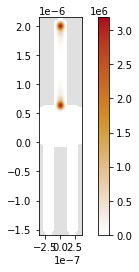

In [85]:
kwant.plotter.density(trijunction, density(vecs[13]));

In [63]:
energies = []

for acumulate in voltage_range:
    voltages = 
    evals, evecs = solver(voltages, extra_params)
    energies.append(evals)

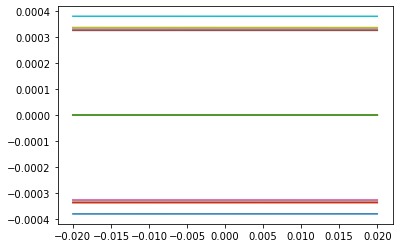

In [65]:
energies = np.array(energies)
for level in energies.T:
    plt.plot(voltage_range, level)

In [64]:
left_right = voltage_dict(depleted, acumulate, arm='top', arm_v=-5e-3)
left_center = voltage_dict(depleted, acumulate, arm='right', arm_v=-5e-3)
right_center = voltage_dict(depleted, acumulate, arm='left', arm_v=-5e-3)

In [66]:
phis = np.linspace(0, 2, 20)*np.pi

In [67]:
phases_0 = [{'phi0': 0, 'phi1': phi} for phi in phis]
phases_1 = [{'phi1': 0, 'phi0': phi} for phi in phis]

In [68]:
args_1 = list(it.product([left_right], phases_0))
args_2 = list(it.product([left_center], phases_0))
args_3 = list(it.product([right_center], phases_1))              

In [72]:
args = args_1 + args_2 + args_3

In [73]:
args_db = db.from_sequence(args)

In [79]:
args_db

dask.bag<from_sequence, npartitions=60>